# Facility Location for temporal markets using PuLP and UrbanPy

### General imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('..')
import urbanpy as up
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import numpy as np
import re
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pulp import *

### Data preparation

First, we need our set of possible facilities to activate. To construct it we will

* Download a administrative limits from one district of Lima, Peru: San Juan de Lurigancho
* Download parks and pitches in the area from OpenStreetMap (OSM)

In [3]:
sjl = up.download.nominatim_osm('San Juan de Lurigancho, Lima')

<Axes: >

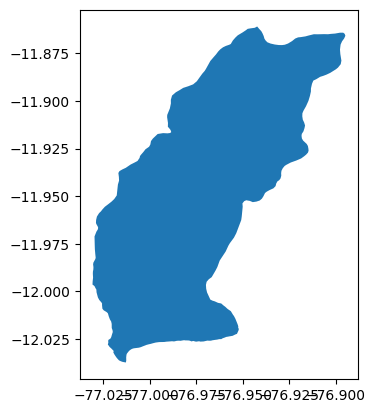

In [4]:
sjl.plot()

Now we are going to create a custom query for the overpass api to download parks an pitches within the district polygon. You can try your own cutom querys [here](https://overpass-turbo.eu/).

In [5]:
parks_pitchs_gdf, _ = up.download.overpass(
    type_of_data="way", 
    query={'leisure': ['park', 'pitch']}, 
    mask=sjl
)

In [6]:
parks_pitchs_gdf.head()

,type,id,bounds,nodes,geometry,tags,poi_type
870,way,523849778,"{'minlat': -12.0255889, 'minlon': -76.9746309,...","[5098961128, 5098961129, 5098961130, 509896113...","POLYGON ((-76.97435 -12.02543, -76.97435 -12.0...","{'leisure': 'pitch', 'sport': 'futsal', 'surfa...",pitch
869,way,523849777,"{'minlat': -12.0255995, 'minlon': -76.9778649,...","[5098961124, 5098961125, 5098961126, 509896112...","POLYGON ((-76.97747 -12.02539, -76.97752 -12.0...","{'leisure': 'pitch', 'sport': 'futsal', 'surfa...",pitch
868,way,523849776,"{'minlat': -12.0254486, 'minlon': -76.9785878,...","[5098961020, 5098961121, 5098961122, 509896112...","POLYGON ((-76.97820 -12.02526, -76.97827 -12.0...","{'leisure': 'pitch', 'sport': 'futsal', 'surfa...",pitch
1609,way,877310877,"{'minlat': -12.0253388, 'minlon': -76.9751268,...","[8162596602, 8162596601, 8162596600, 816259659...","POLYGON ((-76.97484 -12.02518, -76.97485 -12.0...","{'leisure': 'pitch', 'sport': 'futsal', 'surfa...",pitch
1610,way,877310878,"{'minlat': -12.0253534, 'minlon': -76.9764873,...","[8162596606, 8162596605, 8162596604, 816259660...","POLYGON ((-76.97649 -12.02531, -76.97646 -12.0...","{'leisure': 'pitch', 'sport': 'soccer', 'surfa...",pitch


The parks and pitches area in meters is needed to filter the possible candidates with a minimun area. Before calculating the polygon area, first we need to project to UTM

In [7]:
parks_pitchs_gdf_proj = parks_pitchs_gdf.to_crs(epsg=32718) # Project to meters
parks_pitchs_gdf['area'] = parks_pitchs_gdf_proj.geometry.area # Get area in squared meters

We need to caculate distances from other geometries to the polygon data, using the centroid is a simple but fairly good approximation

In [8]:
parks_pitchs_gdf['lat'] = parks_pitchs_gdf.geometry.centroid.y
parks_pitchs_gdf['lon'] = parks_pitchs_gdf.geometry.centroid.x

Construct the candidate set from Overpass POIs

In [9]:
candidates = parks_pitchs_gdf[['id', 'lat', 'lon', 'area']]
candidates = gpd.GeoDataFrame(
    data=candidates, 
    geometry=gpd.points_from_xy(candidates['lon'], candidates['lat']),
    crs='EPSG:4326')

Approximate the candidate capacity using the area 

In [10]:
candidates['aforo'] = (candidates['area'] * 2).apply(np.floor).astype(int)

In [11]:
candidates.head()

,id,lat,lon,area,geometry,aforo
870,523849778,-12.025502,-76.974490,537.490484,POINT (-76.97449 -12.02550),1074
869,523849777,-12.025463,-76.977667,898.427990,POINT (-76.97767 -12.02546),1796
868,523849776,-12.025301,-76.978393,793.000409,POINT (-76.97839 -12.02530),1586
1609,877310877,-12.025251,-76.974984,532.224961,POINT (-76.97498 -12.02525),1064
1610,877310878,-12.025105,-76.976117,3922.148253,POINT (-76.97612 -12.02511),7844


### Add external data to your UrbanPy workflow

We will concatenate candidates with the national market census observations

In [12]:
markets = pd.read_csv('input/market_db.csv')
markets = gpd.GeoDataFrame(
    data=markets, 
    geometry=gpd.points_from_xy(markets['longitude'], markets['latitude']),
    crs = 'EPSG:4326')

Approximate the market capacity using the its reported area

In [13]:
markets['aforo'] = markets.apply(
    lambda row: row['Area construida']*2 if row['Tipo de mercado']=='Minorista' else row['Area construida']*5,
    axis=1
)

In [14]:
# Filter markets inside the area of analysis
merc = markets.clip(mask=sjl)

In [15]:
merc = merc[['aforo', 'longitude', 'latitude', 'geometry']].reset_index()

In [16]:
merc = merc.rename(columns={'index': 'id', 'longitude': 'lon', 'latitude': 'lat'})

In [17]:
merc.shape

(123, 5)

In [18]:
markets = markets.loc[merc.id]

In [19]:
markets.isna().sum()

ID                                            0
Codigo_Departamento                           0
DEPARTAMENTO                                  0
Codigo_Provincia                              0
PROVINCIA                                     0
                                             ..
Egresos por otros gastos especifico (2015)    0
P64_40                                        0
Total de Egresos (2015)                       1
geometry                                      0
aforo                                         0
Length: 365, dtype: int64

In [20]:
candidates = candidates[['id', 'lat', 'lon', 'aforo', 'geometry']]

We will use only 10 candidates for this example, you can increase the number of candidates used. This will also increase the execution time.

In [21]:
N_CANDIDATES = 10

In [22]:
# Select the N_CANDIDATES biggest candidates
candidates = candidates.sort_values('aforo').tail(N_CANDIDATES)

In [23]:
candidates = pd.concat([candidates, merc]).reset_index(drop=True)

In [24]:
candidates.shape

(133, 5)

In [25]:
candidates.head()

,id,lat,lon,aforo,geometry
0,183453731,-12.024563,-76.981002,31096.0,POINT (-76.98100 -12.02456)
1,116948920,-11.970355,-77.007618,34201.0,POINT (-77.00762 -11.97035)
2,119442059,-11.973254,-76.993632,34601.0,POINT (-76.99363 -11.97325)
3,116933484,-11.974345,-77.005239,43102.0,POINT (-77.00524 -11.97434)
4,184184722,-12.006460,-77.013934,43608.0,POINT (-77.01393 -12.00646)


### Creating the demand an "clients" for the FLP

Now, we need to estimate the total population moving to these markets. To achieve this we need to

* Download HDX data
* Filter it to our district
* Convert it to hexagons

In [26]:
per_resources_df = up.download.search_hdx_dataset('peru')
per_resources_df

,created,name,population,size_mb,url
id,,,,,
0,2019-06-11,per_general_2020_csv.zip,Overall population density,33.09,https://data.humdata.org/dataset/4e74db39-87f1...
2,2019-06-11,per_children_under_five_2020_csv.zip,Children (ages 0-5),32.83,https://data.humdata.org/dataset/4e74db39-87f1...
4,2019-06-11,per_elderly_60_plus_2020_csv.zip,Elderly (ages 60+),32.80,https://data.humdata.org/dataset/4e74db39-87f1...
6,2019-06-11,per_men_2020_csv.zip,Men,32.94,https://data.humdata.org/dataset/4e74db39-87f1...
8,2019-06-11,per_women_2020_csv.zip,Women,32.95,https://data.humdata.org/dataset/4e74db39-87f1...
10,2019-06-11,per_women_of_reproductive_age_15_49_2020_csv.zip,Women of reproductive age (ages 15-49),32.89,https://data.humdata.org/dataset/4e74db39-87f1...
12,2019-06-11,per_youth_15_24_2020_csv.zip,Youth (ages 15-24),32.86,https://data.humdata.org/dataset/4e74db39-87f1...


In [27]:
pop = up.download.get_hdx_dataset(per_resources_df, 0)

In [28]:
pop_sjl = up.geom.filter_population(pop, sjl)

In [29]:
hex_sjl = up.geom.gen_hexagons(8, sjl)

<Axes: >

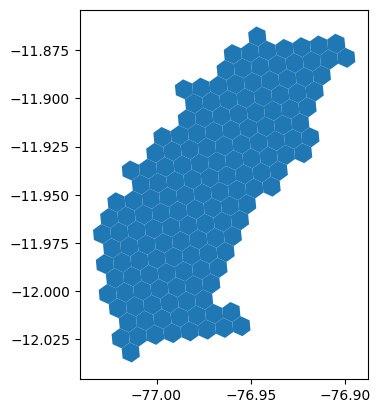

In [30]:
hex_sjl.plot()

Merging both layers

In [31]:
pop_sjl.isna().sum()

longitude           0
latitude            0
per_general_2020    0
geometry            0
dtype: int64

In [32]:
hex_sjl.isna().sum()

hex         0
geometry    0
dtype: int64

In [33]:
hex_sjl = up.geom.merge_shape_hex(
    hex_sjl, 
    pop_sjl, 
    how='inner', 
    predicate='intersects', 
    agg={'per_general_2020': 'sum'}
)

In [34]:
hex_sjl.isna().sum()

hex                  0
geometry             0
per_general_2020    19
dtype: int64

In [35]:
hex_sjl.fillna(0, inplace=True)

<Axes: >

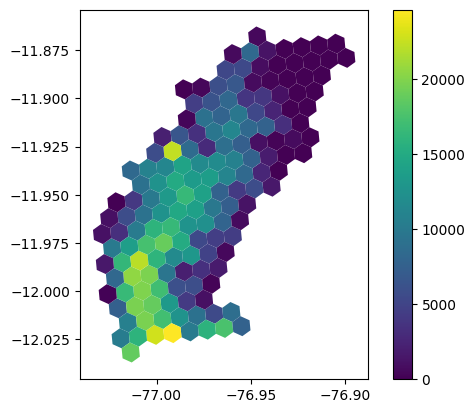

In [36]:
hex_sjl.plot(column='per_general_2020', legend=True)

## Distance matrix calculation

To estimate the cost for our FLP, we will use walking travel time. For this we need to

* Setup the OSRM server
* Get the distance matrix
* Shutdown the server

In [37]:
up.routing.start_osrm_server('peru', 'south-america', 'foot')

Starting server ...
osrm_routing_server_south-america_peru_foot
Server was started succesfully


To compute_osrm_dist_matrix we need Point geometry (We are going to use each hexagon centroid)

In [38]:
hex_sjl_centroids = hex_sjl.copy() # Copy original gdf
hex_sjl_centroids.geometry = hex_sjl_centroids.geometry.centroid # Replace Polygon for Centroid 

In [39]:
print("# of Hexs:", hex_sjl_centroids.shape[0])
print("# of Candidates", candidates.shape[0])

# of Hexs: 160
# of Candidates 133


Now we are going to calculate the distance matrix. This operation is time expensive this may take several minutes ...

In [40]:
try:
    cost_mat = np.load('output/distance_matrix.npy')
except:
    distance, duration = up.routing.compute_osrm_dist_matrix(hex_sjl_centroids, candidates);
    cost_mat = duration.T
    np.save('output/distance_matrix.npy', cost_mat) # save the file to avoid running this function again    

In [41]:
up.routing.stop_osrm_server('peru', 'south-america', 'foot')

Server was stoped succesfully


### Constructing PuLP sets and variables

Set an the number of facilities to be activated, plus the number of current markets

In [42]:
FACILITIES_P = 5

In [43]:
p = FACILITIES_P + merc.shape[0]

In [44]:
p

128

Build the facility and customer set as lists, as per PuLP requirements

In [45]:
candidates = candidates.reset_index(drop=True)

In [46]:
candidates.shape

(133, 5)

In [47]:
customers = list(hex_sjl_centroids.index)
facilities = [f'FAC_{i}' for i in candidates.index]

Now we create dictionaries for the demand and cost, associating each customer (hexagon) to the demand (population) and each facility (park/pitch) the respective cost (travel time) to each customer 

In [48]:
demand = {i: hex_sjl.loc[i, 'per_general_2020'] for i in hex_sjl.index}

In [49]:
cost_dict = {facilities[i]: {customers[j]: cost_mat[i][j] for j in hex_sjl.index} for i in candidates.index}

In [50]:
capacity = {facilities[i]: markets.loc[merc_id, 'aforo'] for i, merc_id in enumerate(merc.id)}

Create problem variable for PuLP

In [51]:
prob = LpProblem('FLP_Markets_SJL', LpMinimize)

We create the decision variable $x_{ij}$, representing the percentage of service assigned from a facility to a customer, setting 0 as the lower bound

In [52]:
x = LpVariable.dicts('Service', 
                    [(i,j) for j in customers for i in facilities],
                    0)

Now we create the decision variable to activate a facility $y_i$

In [53]:
y = LpVariable.dicts('Activation',
                     facilities,
                     0,1, LpBinary)

Setting the objective function $$ \sum_{i=1}^{n} \sum_{j=1}^{m} d_{j} c_{ij} x_{ij} $$

In [54]:
prob += lpSum(lpSum(demand[j]*cost_dict[i][j]*x[i,j] for i in facilities) for j in customers)

We add the first constraint $$ \sum_{i=1}^{n} x_{ij} = 1 \quad \forall j \in \text{Customers}$$

In [55]:
for j in customers:
    prob += lpSum(x[i,j] for i in facilities) == 1

Adding the second constraint $$ \sum_{i=1}^{n} y_{i} = p $$

In [56]:
prob += lpSum(y[i] for i in facilities) == p

Third constraint $$ x_{i,j} ≤ y_{i} \quad \forall i \in \text{Facilities} \quad \forall j \in \text{Customers}$$

In [57]:
for i in facilities:
    for j in customers:
        prob += x[i,j] <= y[i]

We need to keep the markets active, focusing on activating only additional facilities (avoid selecting already active markets)

In [58]:
for i in facilities[N_CANDIDATES:]:
    prob += y[i] == 1

Finally, as to maintain proper social distancing, we set a capacity constraint $$ \sum_{j=1}^{m} x_{ij} ≤ c_{i} \quad \forall i \in \text{Facilities}$$

In [59]:
for i in capacity:
    prob += lpSum(x[i,j] for j in customers) <= capacity[i]

Solve (a custom solver may be added in the solve method)

In [60]:
prob.solve();

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/codespace/.python/current/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/b1873a7dea6045a8ae2aa9078a574ded-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/b1873a7dea6045a8ae2aa9078a574ded-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 21692 COLUMNS
At line 124488 RHS
At line 146176 BOUNDS
At line 146310 ENDATA
Problem MODEL has 21687 rows, 21413 columns and 83776 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2.12301e+09 - 0.03 seconds
Cgl0004I processed model has 1765 rows, 2231 columns (10 integer (10 of which binary)) and 6071 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 2.12301e+09
Cbc0038I Relaxing continuous gives 2.12301e+09
Cbc0038I Before mini branch and bound, 10 integers at bound fixed and

Check solution status

In [61]:
print("Status:", LpStatus[prob.status])

Status: Optimal


Obtain the demand assignments

In [62]:
x_vars = [[0 for j in range(len(customers))] for i in range(len(facilities))]

for v in prob.variables():
    if 'Activation' not in v.name:
        i, j = re.findall('\d+', v.name)
        x_vars[int(i)][int(j)] = v.varValue

In [63]:
y_vars = np.zeros_like(facilities)

for v in prob.variables():
    if 'Activation' in v.name:
        ix = int(re.findall('\d+', v.name)[0])
        y_vars[ix] = v.varValue

y_vars = y_vars.astype(float)

In [64]:
x_vars, y_vars = np.array(x_vars), np.array(y_vars)

Add some flags useful for visualization purposes

In [65]:
candidates['is_active'] = y_vars

In [66]:
candidates['is_market'] = 0

In [67]:
candidates.loc[N_CANDIDATES:, 'is_market'] = 1

Verify that the number of parks and pitches candidates selected is equal to FACILITIES_P

In [68]:
FACILITIES_P == candidates[(candidates['is_active'] == 1) & (candidates['is_market'] == 0)].shape[0]

True

In [69]:
candidates.reset_index(drop=True, inplace=True)

Save results

In [70]:
# Raw
np.save('output/assignments.npy', x_vars)
np.save('output/facilities.npy', y_vars)

In [71]:
# For viz
candidates.to_file('output/facilities', index=False)

In [72]:
park_and_pitches_filter = parks_pitchs_gdf['id'].isin(candidates[candidates['is_market'] == 0]['id'])
park_and_pitches_candidates = parks_pitchs_gdf[park_and_pitches_filter]

In [73]:
park_and_pitches_candidates = park_and_pitches_candidates.merge(
    candidates[['id', 'aforo', 'is_active']], on='id')

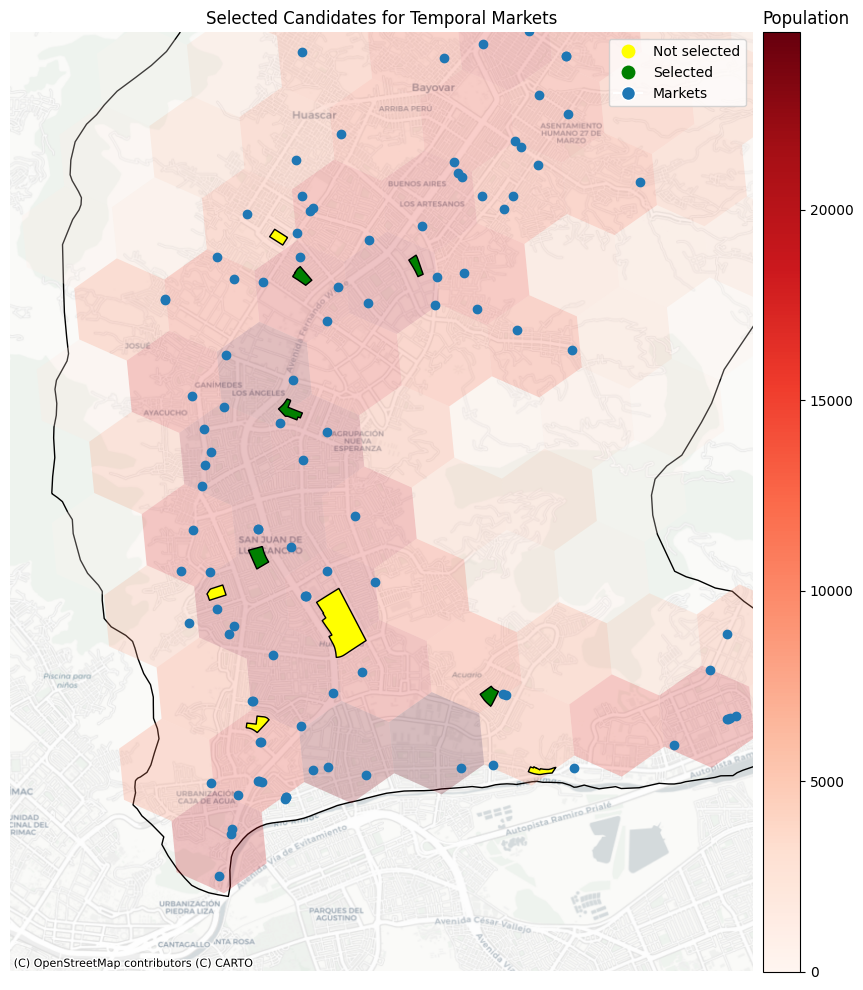

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(40,10))

plt.title('Selected Candidates for Temporal Markets')

# Colorbar for population choropleth map
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cax.set_title('Population', loc='left')

# Administrative boundaries
sjl.plot(facecolor='none', ax=ax) 
# Population
hex_sjl.plot('per_general_2020', cmap='Reds', alpha=0.25, legend=True, ax=ax, cax=cax)
# Current Markets
merc.plot(ax=ax, legend=True)
# Candidates
cmap = ListedColormap(["yellow", "green"])
park_and_pitches_candidates.plot('is_active', cmap=cmap,  edgecolor='k', 
                                 legend=True, categorical=True, ax=ax)


# Format map legend
legend = ax.get_legend()
lines = legend.get_lines()
legend.remove()
markets_legend = Line2D([0], [0], marker='o', color='w', 
                        markerfacecolor='#1f77b4', markersize=10)
lines.append(markets_legend)
texts = ['Not selected', 'Selected', 'Markets']
ax.legend(lines, texts)

# Set map limits
minx, miny, maxx, maxy = park_and_pitches_candidates.total_bounds
margins = 0.02
ax.set_xlim(minx-margins, maxx+margins)
ax.set_ylim(miny-margins, maxy+margins)

# Add a basemap
ax.set_axis_off()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs='EPSG:4326')

plt.tight_layout()